#GPUs

nvidia-smi --query-compute-apps=pid --format=csv,noheader | xargs -I {} ps -p {} -o pid,cmd --no-headers


kill <PID>
kill -9 <PID>            (forces the kill)

In [1]:
# Autoreload 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Bacis libraries #
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Pytorch #
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Lightning #
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CometLogger
from datetime import datetime

# Personal scripts #
path_src = '../src'
if path_src not in sys.path:
    sys.path.insert(0,path_src)
from preprocessing import *
from callbacks import *
from transformer import AnalysisObjectTransformer, Embedding
from losses import * # added Losses for multiclassifier
from plotting import * #plot_roc, plot_confusion_matrix


torch.set_float32_matmul_precision('medium')
accelerator = 'gpu' if torch.cuda.is_available() else "cpu"
print (f"Accelerator : {accelerator}")

Accelerator : gpu


# Import datasets

Our files are in parquet files : one for each process, containing all the event level information

The following lines do the import into a pandas dataframe, and the different preprocessing steps we need (remove negative weight events, make labls, split into training and validation sets, etc)

In [2]:

import sys
import os

# Ensure the src directory is in your path
src_dir = os.path.abspath("../src")
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

from preprocess_cache import get_preprocessed_dataset
from torch.utils.data import DataLoader

# Load cached/preprocessed dataset
data = get_preprocessed_dataset(cache_path="cached_dataset.pkl")
train_dataset      = data["train_dataset"]
valid_dataset      = data["valid_dataset"]
val_weight_nominal = data["val_weight_nominal"]
X = data["X"]
y = data["y"]
pad_mask           = data["pad_mask"]
event_level        = data["event_level"]
reweighting        = data["reweighting"]
weight_nominal_tensor = data["weight_nominal_tensor"]

train_X            = data["train_X"]
val_X              = data["val_X"]
train_y            = data["train_y"]
val_y              = data["val_y"]
train_weights      = data["train_weights"]
val_weights        = data["val_weights"]
train_mask         = data["train_mask"]
val_mask           = data["val_mask"]
train_event        = data["train_event"]
val_event          = data["val_event"]
train_weight_nominal = data["train_weight_nominal"]
outdir             = data["outdir"]
data_columns           = data["data_columns"]



# Create DataLoaders
batch_size = 1024
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=10,
)

valid_loader = DataLoader(
valid_dataset, 
batch_size=10000, 
shuffle=False,
num_workers = 10,
)



Loading preprocessed data from cache...


In [3]:
print(data_columns)

Index(['event', 'region', 'Generator_weight', 'Generator_scalePDF',
       'Generator_x1', 'Generator_x2', 'Generator_xpdf1', 'Generator_xpdf2',
       'cleanedJet_pt', 'cleanedJet_eta', 'cleanedJet_phi', 'cleanedJet_mass',
       'cleanedJet_area', 'cleanedJet_btagDeepFlavB', 'GenMET_pt',
       'GenMET_phi', 'InputMet_pt', 'InputMet_phi', 'ncleanedJet',
       'ncleanedBJet', 'HT', 'MHT_pt', 'MHT_phi', 'InputMet_InputJet_mindPhi',
       'weight_nominal', 'xs_weight', 'Pred', 'cleanedJet_pt_jesAbsolute_up',
       'cleanedJet_pt_jesAbsolute_down', 'cleanedJet_pt_jesBBEC1_up',
       'cleanedJet_pt_jesBBEC1_down', 'cleanedJet_pt_jesEC2_up',
       'cleanedJet_pt_jesEC2_down', 'cleanedJet_pt_jesFlavorQCD_up',
       'cleanedJet_pt_jesFlavorQCD_down', 'cleanedJet_pt_jesHF_up',
       'cleanedJet_pt_jesHF_down', 'cleanedJet_pt_jesRelativeBal_up',
       'cleanedJet_pt_jesRelativeBal_down',
       'cleanedJet_pt_jesAbsolute_2018_up',
       'cleanedJet_pt_jesAbsolute_2018_down', 'cleanedJ

### If Loading checkpoint, skip up to CheckpointCell

# Input plots 

Always a good idea to check the inputs you provide in the training. It is very easy to introduce incorrect data in the training, and then spend hours investigating the problem in the model, only to find the data is nonsensical (the good old "garbage in, garbage out" syndrom).

The plotting scripts below show the inputs features (ie, jet features) as a function of the multiplicity and labels.
- var 0 : $p_T$
- var 1 : $\eta$ #beam axis?
- var 2 : $\phi$ #beam axis? 
- var 3 : mass
- var 4 : area
- var 5 : btag #probability of whether the jet is a btag, assigned by separate algorithm


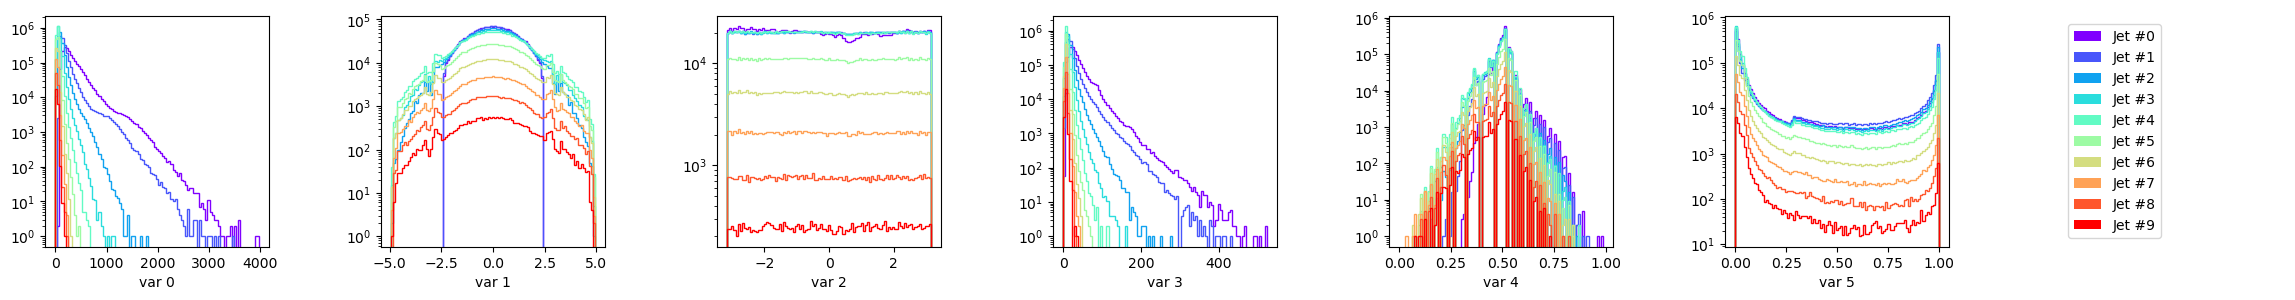

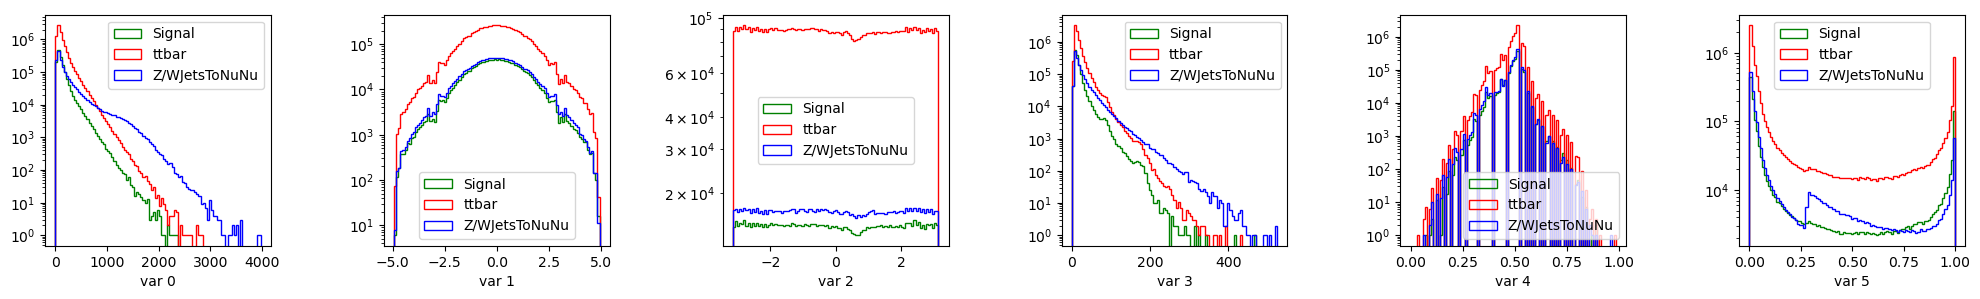

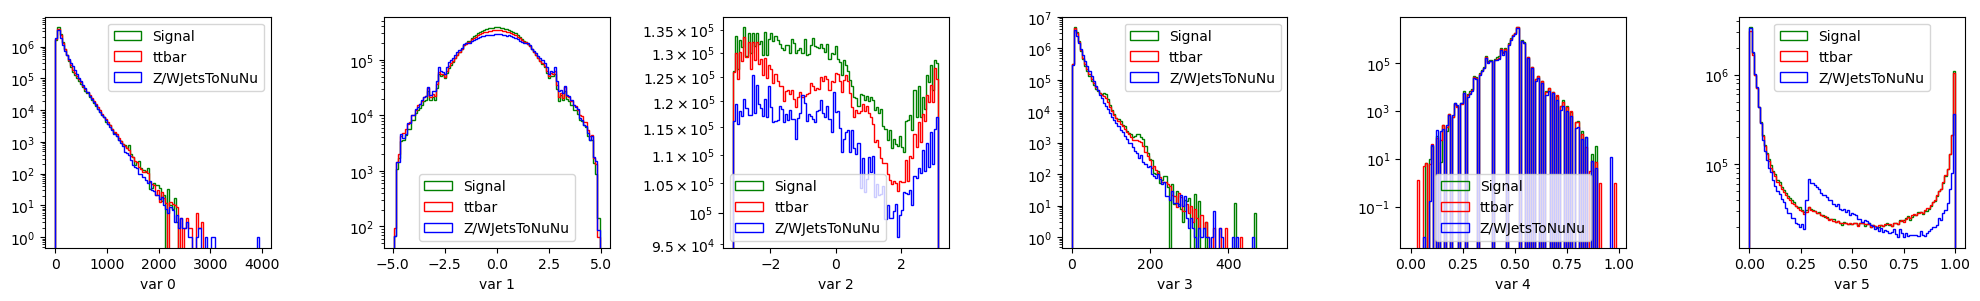

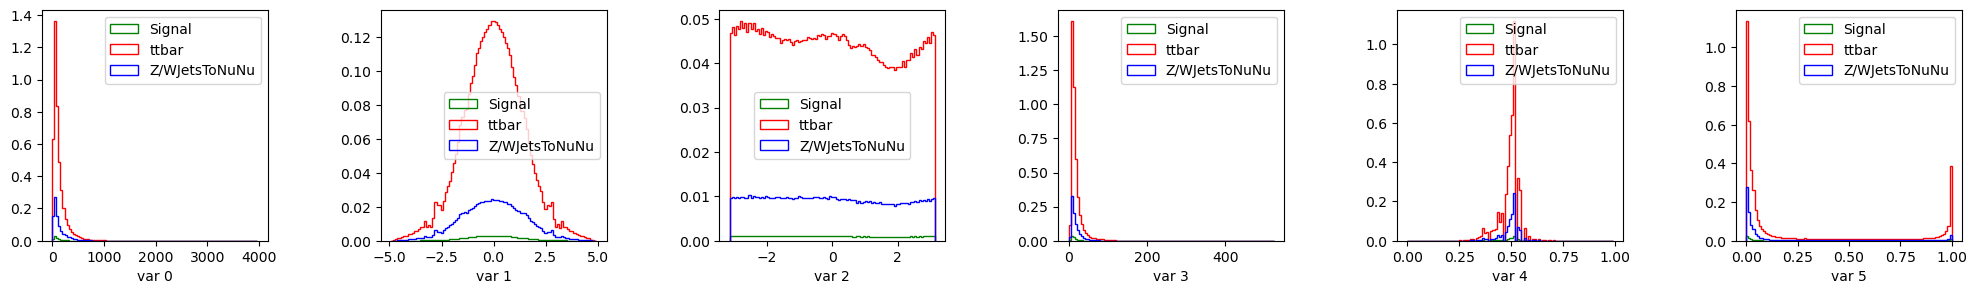

In [5]:
###MULTICLASSIFICATION###

fig = plot_inputs_per_multiplicity(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label_multiclassification(X, y, pad_mask, bins=100, log=True, show=True)
fig = plot_inputs_per_label_multiclassification(X, y, pad_mask, bins=100, weights=reweighting, log=True, show=True)
fig = plot_inputs_per_label_multiclassification(X, y, pad_mask, bins=100, weights=weight_nominal_tensor, log=False, show=True)


# Model
The transformer model can be tweaked with the parameters below (see explanations for each parameter.

The loss function is a composite of BCE, and decorrelation from the MET, to ensure the transformer does not sculpt the latter.

In [20]:
import torch.nn.functional as F

# Define model #

########
#MULTICLASSIFICATION: CrossEntropyLoss, FocalLoss?
########



#loss_function = BCEDecorrelatedLoss(lam = 0.1,weighted=True)
# loss = BCE + lambda * decorrelated loss 
# lambda = 0 -> pure BCE

#loss_function = MulticlassDecorrelatedLoss(lam=0.1, weighted=True) # This is CrossEntropyLoss with decorrelation loss
#loss_function = MulticlassDecorrelatedFocalLoss(gamma=0.5, alpha=None, lam=0.1, weighted=True) #gamma = 0 -> pure crossentropy

gamma = 0.5

loss_function = MulticlassFocalLoss(gamma=gamma, alpha=None, weighted=True)

# Embedding of the jet features into a higher dimension
embedding = Embedding(
    input_dim = train_X.shape[-1],   # Input dimension
    embed_dims = [64],               # Output dimension
    normalize_input = True,          # Whether to apply batch norm before the embedding
)


#LAYERS:
#Play around with the number of encoder layers, class layers and dnn layers.

encoder_layers = 5
class_layers = 3
dnn_layers = 3


model = AnalysisObjectTransformer(
    embedding = embedding,           # Embedding instance
    embed_dim = embedding.dim,       # Embedding dimension
    num_heads = 8,                   # Number of heads for multihead attention (must be a divisor of embed dim)
    output_dim = 3,                  # Output dimension (1 : binary classification, >1 : multi classification) - 4 for multiclass
    expansion_factor = 4,            # Multipliying factor for layers in attention block (neurons = embed_dim * expansion_factor) changed 4 to 2
    encoder_layers = encoder_layers,              # Number of encoder layers (self attention on jets), increased to 5
    class_layers = class_layers,                # Number of class layers (cross attention between jets representations and class token)
    dnn_layers = dnn_layers,                  # Number of layers for DNN after the transformer (most of heavy lifting done by trnasformer, dont need >3)
    hidden_activation = nn.GELU,     # Hidden activation in transformer and DNN
    output_activation = None,        # DNN output activation (sigmoid for binary, softmax for multiclass, None if applied in the loss)
    dropout = 0.1,                  # Dropout rate
    loss_function = loss_function,   # Loss function, see above
)

# Print the model graph #
print (model)
# Quick benchmark test the model #
# To make sure the model will run, we take a single batch from the training and pass it through the model

batch = next(iter(train_loader))

inputs, labels, weights, mask, event = batch
print ('Batch dtypes',inputs.dtype,labels.dtype,weights.dtype,mask.dtype,event.dtype)

outputs = model(inputs,padding_mask=mask)
print ('outputs',outputs .shape)
loss_values = loss_function(outputs,labels,event,weights)
print ('losses',loss_values)

AnalysisObjectTransformer(
  (embedding): Embedding(
    (input_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (encoder_blocks): ModuleList(
    (0-4): 5 x AttBlock(
      (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multihead_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layer_norm3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layer_norm4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (class_blocks): M

# Training 

Writing the training loop can involve a biut of boilerplate code. To bypass that we use the [pytorch-lightning](https://lightning.ai/docs/pytorch/stable/) package to run the training. 

The batch steps were defined in the model class, and now we can use the trainer class from lightning to run the training. This takes care of doing the loop, putting data on the GPU if needed, applying the schedule, etc.

One way to finetune our training (or monitor it) is through callbacks. Callbacks are class objects that are evaluated at different times during the training, and allow the user to access their model. Below we use a few of those :
- model checkpoint : saves the best model parameters at every epoch
- early stopping : if the loss values (of the validation) plateau, stops the training (hopefully before overtraining)
- plotting : a plotting callback we wrote to plot the classification metrics at every epoch
- a few other tweaks

Lighting also allows several plotter interface, we use `comet` to log all our metrics (and callback plots) online. You will need an account [here](https://www.comet.com/signup), you can use your github account if you want.

In [21]:
##### Parameters #####
epochs = 100 #was 500
lr = 1e-4

steps_per_epoch_train = math.ceil(len(train_dataset)/train_loader.batch_size)
steps_per_epoch_valid = math.ceil(len(valid_dataset)/valid_loader.batch_size)

print (f'Training   : Batch size = {train_loader.batch_size} => {steps_per_epoch_train} steps per epoch')
print (f'Validation : Batch size = {valid_loader.batch_size} => {steps_per_epoch_valid} steps per epoch')

# Setup optimizer #
optimizer = optim.Adam(model.parameters(), lr=lr)
model.set_optimizer(optimizer)

# Setup scheduler #
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
   optimizer = optimizer,
   mode = 'min', 
   factor = 0.2, 
   patience = 4,               #reduce the learning rate after 4 (was 10) epochs without improvement
   threshold = 0.,              #threshold for measuring the new optimum
   threshold_mode = 'rel', 
   cooldown = 0, 
   min_lr = 1e-8,               #minimum learning rate
)

model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True,
        'name' : 'lr',
    }
)

# Setup callbacks #
checkpoint_callback = ModelCheckpoint(
    dirpath=outdir,  # Directory where checkpoints will be saved
    filename="best-checkpoint",  # Checkpoint filename
    monitor="val/loss_tot",  # Monitor validation loss
    mode="min",  # Save the best model with the minimum validation loss
    save_top_k=1  # Save only the best model
)

early_stopping = EarlyStopping(
    monitor='val/loss_tot',  # Metric to monitor
    patience=4,          # Number of epochs with no improvement after which training will be stopped
    verbose=True,
    mode='min'           # 'min' for loss, 'max' for accuracy
)

log_bar = L.pytorch.callbacks.TQDMProgressBar(refresh_rate=steps_per_epoch_train//100)

plots_callback = EpochEndCallback_Multiclass(
    data = valid_loader,
    frequency = 1,
    subcallbacks = [
        ScoreSubCallback_Multiclass(name='score',bins=100,log=True),
        CorrelationSubCallback(name='corr',bins=100,log=True),
        ROCSubCallback_Multiclass(name='ROC'),
        ConfusionMatrixSubCallback_Multiclass(name='CM'),
    ]
)

## Logger ##
##Commented out for now to avoid large comet log files

logger = CometLogger(
    #api_key = os.getenv("COMET_API_KEY"),
    #api_key = "",
    project_name = "MSci-AnalysisObjectTransformer",
    experiment_name = f"3 BG, FL ({gamma}gamma): {lr}lr, {encoder_layers}enc, {class_layers}clas, {dnn_layers}dnn",
    save_dir = "./comet_logs",  # Specify where to save Comet logs if offline
    offline = False  # Set to True for offline mode
)

## Trainer ##
trainer = L.Trainer(
    #strategy = "ddp_notebook",  # Use distributed data parallel
    default_root_dir = outdir,
    accelerator = accelerator,
    devices = 1,#[2,3,4], # Number of GPUs. Notebook only supports 1
    max_epochs = epochs,  # Specify the number of epochs
    log_every_n_steps = steps_per_epoch_train,
    check_val_every_n_epoch = 1,  # Check validation every n epochs
    callbacks = [
        checkpoint_callback, 
        early_stopping,
        log_bar,
        #plots_callback,
    ],
    logger = logger,
    # limit_train_batches = 10,
    # limit_val_batches = 1,
    # limit_test_batches = 1,
)

trainer.fit(
    model = model, 
    train_dataloaders = train_loader, 
    val_dataloaders = valid_loader,
)

trainer.save_checkpoint(f"{outdir}/model.pt")

Training   : Batch size = 1024 => 1561 steps per epoch
Validation : Batch size = 10000 => 40 steps per epoch


CometLogger will be initialized in offline mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /users/da21592/msci_project/transformer_renewed/bristol-tth-transformer-msc_project/notebooks/model_training/MulticlassTransformer3BG_20250313_124646 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | embedding      | Embedding           | 460    | t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved. New best score: 2.107


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.032 >= min_delta = 0.0. New best score: 2.075


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.093 >= min_delta = 0.0. New best score: 1.983


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.016 >= min_delta = 0.0. New best score: 1.966


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.027 >= min_delta = 0.0. New best score: 1.939


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.046 >= min_delta = 0.0. New best score: 1.893


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.017 >= min_delta = 0.0. New best score: 1.876


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.027 >= min_delta = 0.0. New best score: 1.849


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.020 >= min_delta = 0.0. New best score: 1.829


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 1.823


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.009 >= min_delta = 0.0. New best score: 1.813


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 1.806


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.014 >= min_delta = 0.0. New best score: 1.792


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 1.790


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.014 >= min_delta = 0.0. New best score: 1.775


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 1.769


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 1.762


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 1.758


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/loss_tot did not improve in the last 4 records. Best score: 1.758. Signaling Trainer to stop.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : 3 BG, FL (0.5gamma): 0.0001lr, 5enc, 3clas, 3dnn
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train/loss_tot [30] : (1.5287226438522339, 2.1100270748138428)
COMET INFO:     val/loss_tot [30]   : (1.7584866285324097, 2.1069376468658447)
COMET INFO:   Others:
COMET INFO:     Created from       : pytorch-lightning
COMET INFO:     Name               : 3 BG, FL (0.5gamma): 0.0001lr, 5enc, 3clas, 3dnn
COMET INFO:     offline_experiment : T

### Load Checkpoint Here, else skip

- Run everything from start, skipping trainer cell, then run the below cells.

In [4]:
import torch
import torch.nn as nn

# Path to your checkpoint
checkpoint_path = "./model_training/MulticlassTransformer3BG_20250313_124646//model.pt"

# Create the loss function that matches what was used during training
loss_function = MulticlassFocalLoss(gamma=0, alpha=None, weighted=True)

# Create the embedding with the CORRECT input dimension (important!)
# This must match the dimension used during original training
embedding = Embedding(
    input_dim = 6,  # Make sure this is the number of jet features used in training
    embed_dims = [64],
    normalize_input = True,
)

# Now load the checkpoint
print("Loading checkpoint from:", checkpoint_path)
checkpoint = torch.load(checkpoint_path, map_location="cpu")

# Print some checkpoint info to verify
print(f"Checkpoint keys: {list(checkpoint.keys())}")
if 'hyper_parameters' in checkpoint:
    print(f"Original parameters: {checkpoint['hyper_parameters']}")

# Create model with the same architecture as used in training
model = AnalysisObjectTransformer(
    embedding = embedding,
    embed_dim = embedding.dim,
    num_heads = 8,
    output_dim = 3,  # Number of classes (ttH, ttbar, Z/W+jets)
    expansion_factor = 4,
    encoder_layers = 5,
    class_layers = 3,
    dnn_layers = 3,
    hidden_activation = nn.GELU,
    output_activation = None,
    dropout = 0.1,
    loss_function = loss_function,
)

# Load the state dict
missing_keys = model.load_state_dict(checkpoint["state_dict"], strict=False)
print(f"Missing keys: {missing_keys}")

# Set model to evaluation mode
model.eval()
print("Model loaded successfully!")

Loading checkpoint from: ./model_training/MulticlassTransformer3BG_20250313_124646//model.pt
Checkpoint keys: ['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers']
Missing keys: <All keys matched successfully>
Model loaded successfully!


/tmp/ipykernel_3564291/173619375.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="cpu")


### continue

In [5]:
# ## Testing model performance on validation set ##




## Testing model performance on validation set ##
trainer = L.Trainer(accelerator=accelerator, devices=1)

preds = trainer.predict(model=model, dataloaders=valid_loader)
preds = torch.cat(preds, dim=0)


# Get data
inputs, labels, weights, mask, event = valid_dataset.tensors

probs = torch.softmax(preds, dim=1)  # Convert to probabilities

# Get predicted classes
pred_classes = torch.argmax(probs, dim=1)

# Calculate accuracy per class
for i in range(3):
    mask_i = labels == i
    acc_i = (pred_classes[mask_i] == labels[mask_i]).float().mean()
    print(f"Class {i} accuracy: {acc_i:.3f}")

# Overall accuracy
acc = (pred_classes == labels).float().mean()
print(f"\nOverall accuracy: {acc:.3f}")

print(f"\nPredictions shape: {preds.shape}")  # Should show 3 classes in second dimension

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]


Predicting: |          | 0/? [00:00<?, ?it/s]

Class 0 accuracy: 0.644
Class 1 accuracy: 0.646
Class 2 accuracy: 0.707

Overall accuracy: 0.654

Predictions shape: torch.Size([399567, 3])


In [1]:
# import torch
# from torch.utils.data import DataLoader, TensorDataset
# import numpy as np
# import matplotlib.pyplot as plt

# def evaluate_accuracy(model, loader):
#     """Compute accuracy over an entire loader."""
#     device = next(model.parameters()).device
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels, weights, mask, event in loader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             mask   = mask.to(device)
#             outputs = model(inputs, padding_mask=mask)
#             preds = outputs.argmax(dim=1)
#             correct += (preds == labels).sum().item()
#             total += labels.numel()
#     return correct / total

# def permutation_importance(model, base_score, inputs, labels, weights, mask, event, feature_names):
#     """
#     Shuffle each feature in 'inputs' and measure the drop in accuracy vs 'base_score'.
#     'inputs' is shape (N, seq_len, n_features).
#     """
#     device = next(model.parameters()).device
#     model.eval()

#     # Move everything to CPU if it fits in memory more comfortably:
#     inputs_cpu = inputs.cpu().clone()
#     labels_cpu = labels.cpu()
#     weights_cpu = weights.cpu()
#     mask_cpu = mask.cpu()
#     event_cpu = event.cpu()

#     n_features = inputs_cpu.shape[-1]
#     importances = np.zeros(n_features)

#     # We reconstruct a DataLoader for each feature shuffle
#     # for measuring the new accuracy
#     def make_loader(inp, lbl, w, m, evt):
#         dataset = TensorDataset(inp, lbl, w, m, evt)
#         return DataLoader(dataset, batch_size=10000, shuffle=False)

#     for feat_idx in range(n_features):
#         # Backup the original column
#         original_col = inputs_cpu[:,:,feat_idx].clone()

#         # Shuffle that column across all samples
#         permutation = torch.randperm(inputs_cpu.shape[0])
#         inputs_cpu[:,:,feat_idx] = inputs_cpu[permutation,:,feat_idx]

#         # Evaluate accuracy
#         new_loader = make_loader(inputs_cpu, labels_cpu, weights_cpu, mask_cpu, event_cpu)
#         shuffled_score = evaluate_accuracy(model, new_loader)

#         importances[feat_idx] = base_score - shuffled_score  # how much accuracy dropped

#         # Restore the column
#         inputs_cpu[:,:,feat_idx] = original_col

#     # Now we have an array of importances, indexed by feature index
#     # We'll plot the top 10
#     top_k = 10
#     sorted_indices = np.argsort(importances)[::-1]  # descending
#     top_indices = sorted_indices[:top_k]

#     # If you have fewer than 'top_k' features or a feature_names list:
#     names = [feature_names[i] for i in top_indices] if feature_names else [str(i) for i in top_indices]
#     vals  = importances[top_indices]

#     plt.figure(figsize=(8,4))
#     plt.bar(range(len(vals)), vals, tick_label=names)
#     plt.xticks(rotation=45, ha='right')
#     plt.ylabel("Drop in Accuracy")
#     plt.title(f"Top {top_k} Feature Importances (Permutation)")
#     plt.tight_layout()
#     plt.show()

#     return importances

# # ---------------------------------------------------------
# # USAGE EXAMPLE (place this after your existing validation code)
# # ---------------------------------------------------------

# # 1. Compute baseline accuracy on validation set
# base_acc = evaluate_accuracy(model, valid_loader)
# print(f"Baseline validation accuracy: {base_acc:.3f}")

# # 2. Retrieve the entire validation set from valid_dataset
# val_inputs, val_labels, val_weights, val_mask, val_event = valid_dataset.tensors

# # Suppose these are your 6 per-jet feature names:
# base_features = ["pt","eta","phi","mass","area","btagDeepFlavB"]

# # Expand them for up to 10 jets (just an example)
# feature_names_60 = []
# for jet_idx in range(10):
#     for feat in base_features:
#         feature_names_60.append(f"{feat}_jet{jet_idx}")

# # Then pass feature_names_60 to your feature-importance routine.
# # E.g. for a bar chart:
# permutation_importance(
#     model=model,
#     base_score=base_acc,  
#     inputs=val_inputs, 
#     labels=val_labels,
#     weights=val_weights,
#     mask=val_mask,
#     event=val_event,
#     feature_names=feature_names_60
# )

In [2]:

# import shap
# import torch
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(f"Using device: {device}")

# # Assuming 'model' is your trained PyTorch model
# # and 'valid_loader' is your validation data loader

# # Ensure model is in evaluation mode and on the correct device
# model.eval()
# model.to(device)

# # --- Optimization: Reduce data size ---
# num_background_samples = 100
# num_explainable_samples = 100

# # Get a batch of data for background/reference and move it to the correct device
# # Extract the inputs tensor directly from the valid_loader
# inputs, labels, weights, mask, event = next(iter(valid_loader))
# background_data = inputs[:num_background_samples].to(device)  # Use the first element (input features)
# explainable_data = inputs[:num_explainable_samples].to(device)

# # Reshape both background_data and explainable_data to match the model's expected input shape
# background_data_reshaped = background_data.reshape(num_background_samples, 10, 6)
# explainable_data_reshaped = explainable_data.reshape(num_explainable_samples, 10, 6)

# # Choose an explainer (DeepExplainer or GradientExplainer)
# explainer = shap.GradientExplainer(model, background_data_reshaped)

# # Calculate SHAP values
# shap_values_full = explainer.shap_values(explainable_data_reshaped, nsamples=200)  # shape => (100, 10, 6, 3)

# # --- Select only the ttH class (class 0) from the last dimension ---
# # (If shap_values_full is (N, 10, 6, 3), this picks out the 0th class => shape (N, 10, 6))
# shap_values = shap_values_full[..., 0]

# print("Shape of shap_values before flattening:", shap_values.shape)
# print("Shape of explainable_data:", explainable_data.shape)

# # Flatten shap_values to (num_explainable_samples, 60)
# shap_values = shap_values.reshape(num_explainable_samples, -1)

# # Flatten features similarly: (num_explainable_samples, 60)
# features = explainable_data_reshaped.reshape(num_explainable_samples, -1).cpu().numpy()

# # Debug: Print the shapes
# print("Shape of shap_values after flattening:", shap_values.shape)
# print("Shape of features after flattening:", features.shape)

# # If you have exact feature names, e.g., data_columns with length 60:
# feature_names = data_columns

# # Summarize feature importance
# shap.summary_plot(shap_values, features=features, feature_names=feature_names)


In [10]:
data_columns

Index(['event', 'region', 'Generator_weight', 'Generator_scalePDF',
       'Generator_x1', 'Generator_x2', 'Generator_xpdf1', 'Generator_xpdf2',
       'cleanedJet_pt', 'cleanedJet_eta', 'cleanedJet_phi', 'cleanedJet_mass',
       'cleanedJet_area', 'cleanedJet_btagDeepFlavB', 'GenMET_pt',
       'GenMET_phi', 'InputMet_pt', 'InputMet_phi', 'ncleanedJet',
       'ncleanedBJet', 'HT', 'MHT_pt', 'MHT_phi', 'InputMet_InputJet_mindPhi',
       'weight_nominal', 'xs_weight', 'Pred', 'cleanedJet_pt_jesAbsolute_up',
       'cleanedJet_pt_jesAbsolute_down', 'cleanedJet_pt_jesBBEC1_up',
       'cleanedJet_pt_jesBBEC1_down', 'cleanedJet_pt_jesEC2_up',
       'cleanedJet_pt_jesEC2_down', 'cleanedJet_pt_jesFlavorQCD_up',
       'cleanedJet_pt_jesFlavorQCD_down', 'cleanedJet_pt_jesHF_up',
       'cleanedJet_pt_jesHF_down', 'cleanedJet_pt_jesRelativeBal_up',
       'cleanedJet_pt_jesRelativeBal_down',
       'cleanedJet_pt_jesAbsolute_2018_up',
       'cleanedJet_pt_jesAbsolute_2018_down', 'cleanedJ

In [9]:
data.columns

AttributeError: 'dict' object has no attribute 'columns'

In [6]:
print("Shape of shap_values:", shap_values.shape)
print("Shape of features:", features.shape)

NameError: name 'shap_values' is not defined

In [27]:

# Assuming you have:
# - probs: model output probabilities (softmaxed)
# - labels: true labels (0=ttH, 1=ttbar, 2=V+jets)
# - val_weight_nominal: event weights

# Convert to numpy
probs_np = probs.detach().cpu().numpy()
labels_np = labels.detach().cpu().numpy()
weights_np = val_weight_nominal.detach().cpu().numpy() * 200000

# Extract ttH probabilities
ttH_probs = probs_np[:, 0]

# Create the plot
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

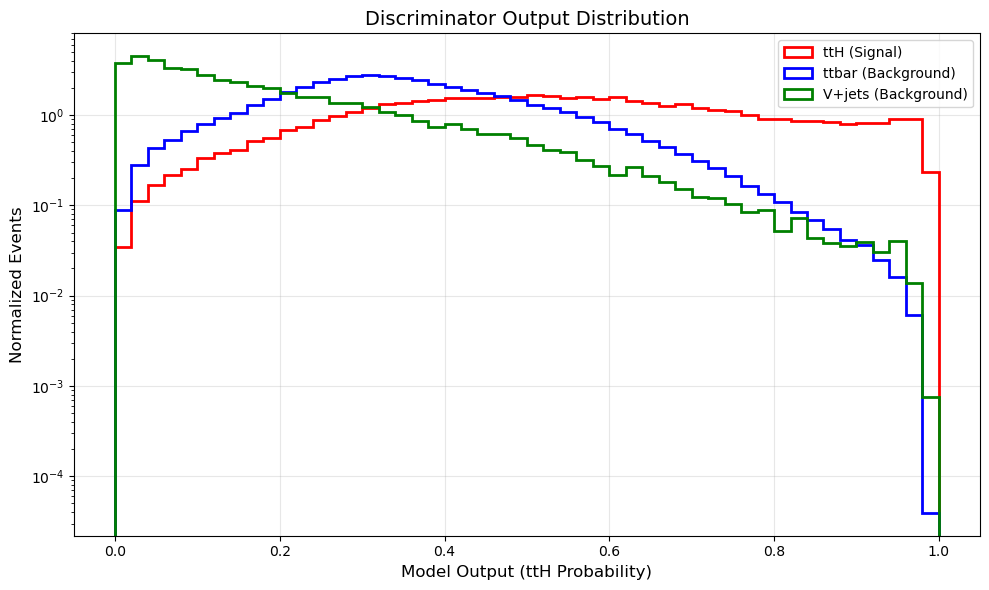

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch


# Plot ttH
plt.hist(ttH_probs[labels_np == 0], 
         bins=50, 
         range=(0, 1), 
         density=True,
         weights=weights_np[labels_np == 0], 
         histtype='step', 
         label='ttH (Signal)', 
         color='red',
         linewidth=2)

# Plot ttbar
plt.hist(ttH_probs[labels_np == 1], 
         bins=50, 
         range=(0, 1), 
         density=True,
         weights=weights_np[labels_np == 1], 
         histtype='step', 
         label='ttbar (Background)', 
         color='blue',
         linewidth=2)

# Plot V+jets
plt.hist(ttH_probs[labels_np == 2], 
         bins=50, 
         range=(0, 1), 
         density=True,
         weights=weights_np[labels_np == 2], 
         histtype='step', 
         label='V+jets (Background)', 
         color='green',
         linewidth=2)

# Customize the plot
plt.xlabel('Model Output (ttH Probability)', fontsize=12)
plt.ylabel('Normalized Events', fontsize=12)
plt.title('Discriminator Output Distribution', fontsize=14)
plt.yscale('log')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

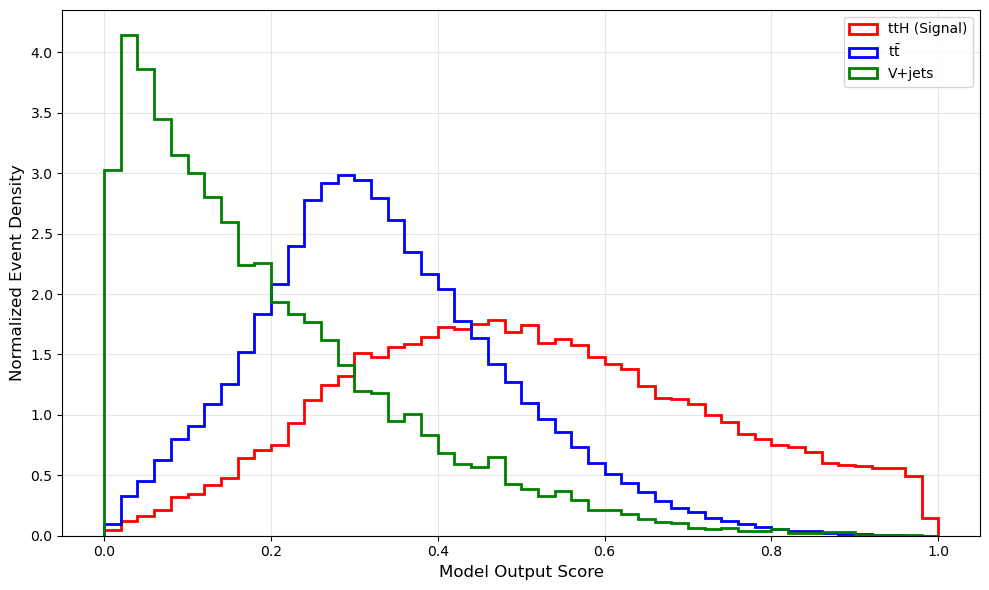

In [15]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot ttH
plt.hist(ttH_probs[labels_np == 0], 
         bins=50, 
         range=(0, 1), 
         density=True,
         weights=weights_np[labels_np == 0], 
         histtype='step', 
         label='ttH (Signal)', 
         color='red',
         linewidth=2)

# Plot ttbar
plt.hist(ttH_probs[labels_np == 1], 
         bins=50, 
         range=(0, 1), 
         density=True,
         weights=weights_np[labels_np == 1], 
         histtype='step', 
         label=r"t$\bar{\mathrm{t}}$", 
         color='blue',
         linewidth=2)

# Plot V+jets
plt.hist(ttH_probs[labels_np == 2], 
         bins=50, 
         range=(0, 1), 
         density=True,
         weights=weights_np[labels_np == 2], 
         histtype='step', 
         label='V+jets',
         color='green',
         linewidth=2)

# Customize the plot
plt.xlabel('Model Output Score', fontsize=12)
plt.ylabel('Normalized Event Density', fontsize=12)
#plt.title('Discriminator Output Distribution', fontsize=14)
#plt.yscale('log')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot multiclass ROC curves
fig = plot_multiclass_roc(labels, probs, outdir=outdir, show=True)


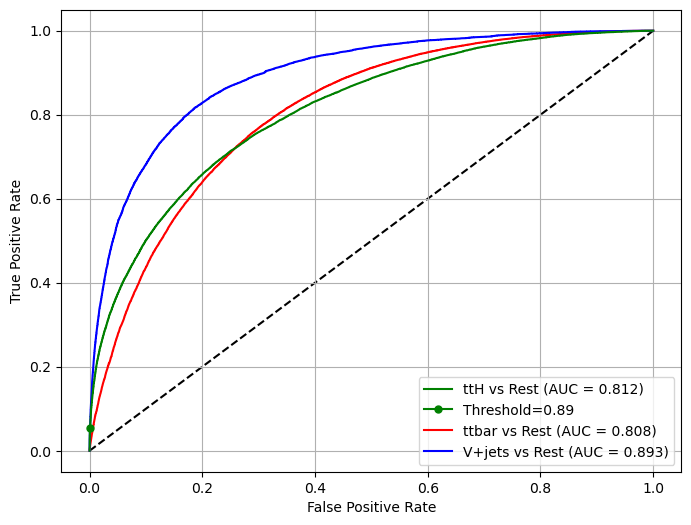

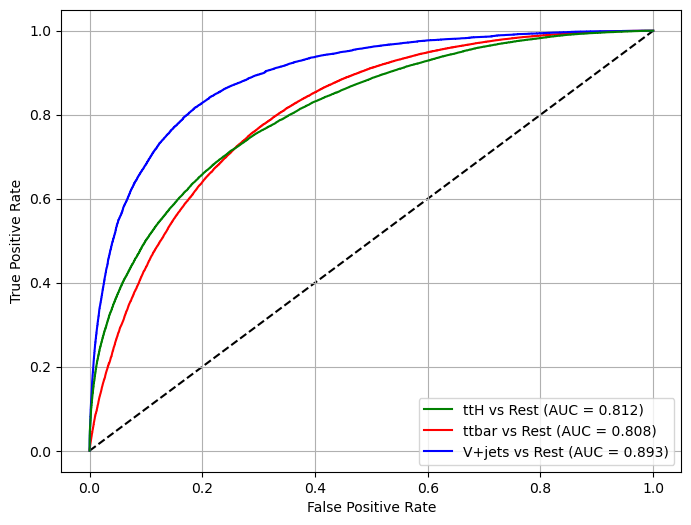

In [9]:
# ...existing code...
# ...existing code...
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import numpy as np

# ...existing code...
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import numpy as np

# ...existing code...
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_multiclass_roc_local(labels, predictions, weights=None, threshold=None, outdir=None, show=False):
    """Plot ROC curves for multiclass predictions using one-vs-rest approach"""
    if torch.is_tensor(labels):
        labels = labels.cpu().numpy()
    if torch.is_tensor(predictions):
        predictions = predictions.cpu().numpy()

    # Setup plot
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ['g', 'r', 'b']  # Three colors for three classes
    class_names = ['ttH', 'ttbar', 'V+jets']  # Three class names

    # Plot ROC curve for each class vs rest
    for i in range(3):  # Three classes
        binary_labels = (labels == i).astype(int)
        class_probs = predictions[:, i]

        # Apply weights if provided
        if weights is not None:
            fpr, tpr, thresholds = roc_curve(binary_labels, class_probs, sample_weight=weights)
        else:
            fpr, tpr, thresholds = roc_curve(binary_labels, class_probs)

        roc_auc = auc(fpr, tpr)

        # Plot ttH first so it's on top
        if i == 0:
            ax.plot(fpr, tpr, color=colors[i], label=f'{class_names[i]} vs Rest (AUC = {roc_auc:.3f})', zorder=3)
            # Find index of threshold for ttH class only
            if threshold is not None:
                idx = np.argmin(np.abs(thresholds - threshold))
                ax.plot(fpr[idx], tpr[idx], marker='o', color=colors[i], markersize=5,
                        label=f'Threshold={threshold:.2f}', zorder=3)
        else:
            ax.plot(fpr, tpr, color=colors[i], label=f'{class_names[i]} vs Rest (AUC = {roc_auc:.3f})', zorder=2)

    ax.plot([0, 1], [0, 1], 'k--', zorder=1)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    #ax.set_title('Multiclass ROC Curves (One-vs-Rest)')
    ax.legend()
    ax.grid(True)
    if show:
        plt.show()

    return fig
# ...existing code...


fig = plot_multiclass_roc_local(labels, probs, outdir=outdir, weights=weights,threshold=0.89, show=True)
fig = plot_multiclass_roc_local(labels, probs, outdir=outdir, weights=weights, show=True)



# Plotting Significance (Z-Score) 


No systematic:
Max significance: 6.52
At threshold: 0.890
S: 33.3
B: 26.2

5% systematic:
Max significance: 6.32
At threshold: 0.890
S: 33.3
B: 26.2

10% systematic:
Max significance: 5.95
At threshold: 0.920
S: 22.2
B: 12.4


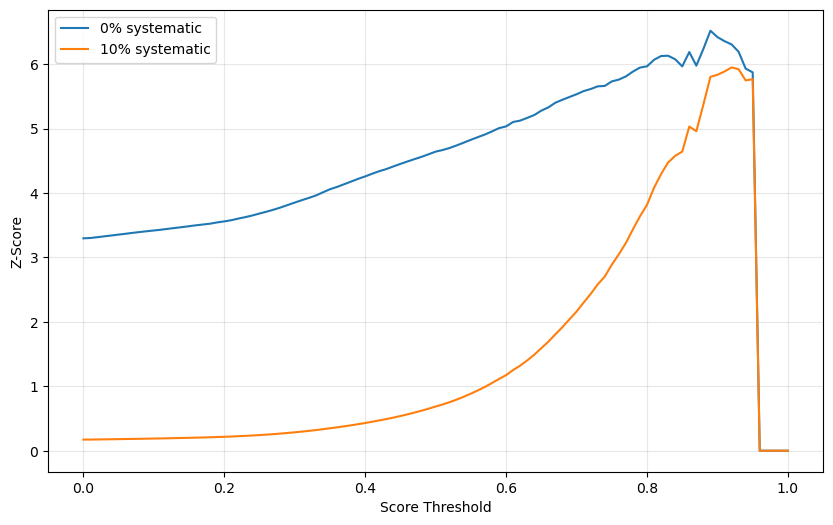

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Convert model outputs to probabilities for each class using softmax (preds.shape => [N, 3])


# Assuming preds[:, 0] corresponds to signal probability
pred_probs = torch.softmax(preds, dim=1).detach().cpu().numpy()  # shape (N,3)

# For Z-score calculation, use probability of signal (class=0)
signal_scores = pred_probs[:, 0].flatten()

# Ground truth: 0 => signal, 1 or 2 => background
truth = labels.detach().cpu().numpy().flatten()

# Weigh events (example: multiply nominal weights by 2e5 for convenience)
#event_weights_np = val_weight_nominal.clone().detach().cpu().numpy().flatten() * 200000
event_weights_np = np.array((val_weight_nominal *200000).flatten())

# Prepare thresholds
thresh_points = np.linspace(0, 1, 101)
significance_0 = []
significance_5 = []
significance_10 = []

for cut in thresh_points:
    # Events passing threshold
    signal_mask = (signal_scores > cut) & (truth == 0)
    bkg_mask = (signal_scores > cut) & (truth != 0)
    
    # Weighted S and B
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    
    if S >= 2 and B >= 2:
        significance_0.append(S / np.sqrt(B))
        significance_5.append(S / np.sqrt(B + (0.05 * B) ** 2))
        significance_10.append(S / np.sqrt(B + (0.10 * B) ** 2))
    else:
        significance_0.append(0)
        significance_5.append(0)
        significance_10.append(0)

# Find max significance & thresholds
max_0 = np.max(significance_0)
max_5 = np.max(significance_5)
max_10 = np.max(significance_10)

idx_0 = np.argmax(significance_0)
idx_5 = np.argmax(significance_5)
idx_10 = np.argmax(significance_10)

thresh_0 = thresh_points[idx_0]
thresh_5 = thresh_points[idx_5]
thresh_10 = thresh_points[idx_10]

# Print info at these thresholds
for thresh_val, sig, label in zip(
    [thresh_0, thresh_5, thresh_10],
    [max_0, max_5, max_10],
    ['No systematic', '5% systematic', '10% systematic']
):
    signal_mask = (signal_scores > thresh_val) & (truth == 0)
    bkg_mask = (signal_scores > thresh_val) & (truth != 0)
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    
    print(f"\n{label}:")
    print(f"Max significance: {sig:.2f}")
    print(f"At threshold: {thresh_val:.3f}")
    print(f"S: {S:.1f}")
    print(f"B: {B:.1f}")

# Plot
plt.figure(figsize=(10,6))
plt.plot(thresh_points, significance_0, label=f'0% systematic')
#plt.plot(thresh_points, significance_5, label=f'5% systematic, Max Z-Score: {max_5:.2f}')
plt.plot(thresh_points, significance_10, label=f'10% systematic')

plt.xlabel('Score Threshold')
plt.ylabel('Z-Score')
#plt.title('Multiclass Z-Score vs Threshold')
plt.grid(alpha=0.3)
plt.legend(loc='upper left')
plt.show()


No systematic:
Max significance: 6.52
At threshold: 0.890
S: 33.3
B: 26.2

5% systematic:
Max significance: 6.32
At threshold: 0.890
S: 33.3
B: 26.2

10% systematic:
Max significance: 5.95
At threshold: 0.920
S: 22.2
B: 12.4


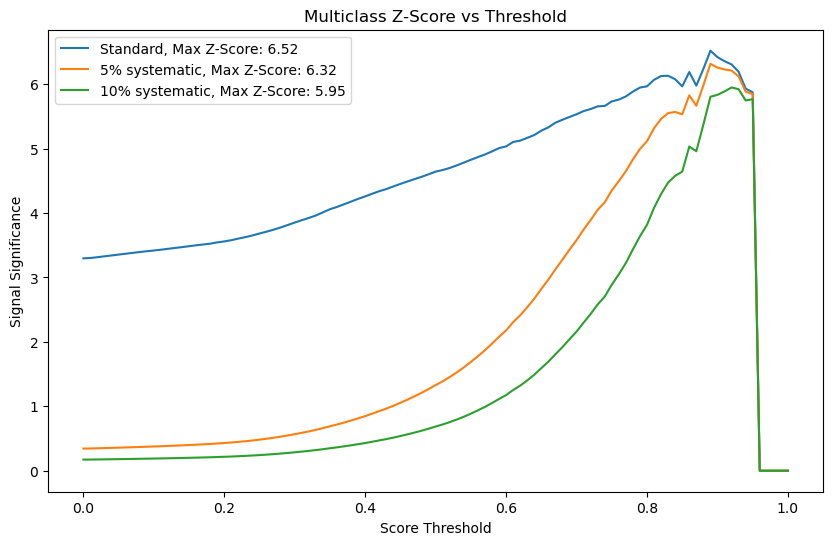

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Convert model outputs to probabilities for each class using softmax (preds.shape => [N, 3])


# Assuming preds[:, 0] corresponds to signal probability
pred_probs = torch.softmax(preds, dim=1).detach().cpu().numpy()  # shape (N,3)

# For Z-score calculation, use probability of signal (class=0)
signal_scores = pred_probs[:, 0].flatten()

# Ground truth: 0 => signal, 1 or 2 => background
truth = labels.detach().cpu().numpy().flatten()

# Weigh events (example: multiply nominal weights by 2e5 for convenience)
#event_weights_np = val_weight_nominal.clone().detach().cpu().numpy().flatten() * 200000
event_weights_np = np.array((val_weight_nominal *200000).flatten())

# Prepare thresholds
thresh_points = np.linspace(0, 1, 101)
significance_0 = []
significance_5 = []
significance_10 = []

for cut in thresh_points:
    # Events passing threshold
    signal_mask = (signal_scores > cut) & (truth == 0)
    bkg_mask = (signal_scores > cut) & (truth != 0)
    
    # Weighted S and B
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    
    if S >= 2 and B >= 2:
        significance_0.append(S / np.sqrt(B))
        significance_5.append(S / np.sqrt(B + (0.05 * B) ** 2))
        significance_10.append(S / np.sqrt(B + (0.10 * B) ** 2))
    else:
        significance_0.append(0)
        significance_5.append(0)
        significance_10.append(0)

# Find max significance & thresholds
max_0 = np.max(significance_0)
max_5 = np.max(significance_5)
max_10 = np.max(significance_10)

idx_0 = np.argmax(significance_0)
idx_5 = np.argmax(significance_5)
idx_10 = np.argmax(significance_10)

thresh_0 = thresh_points[idx_0]
thresh_5 = thresh_points[idx_5]
thresh_10 = thresh_points[idx_10]

# Print info at these thresholds
for thresh_val, sig, label in zip(
    [thresh_0, thresh_5, thresh_10],
    [max_0, max_5, max_10],
    ['No systematic', '5% systematic', '10% systematic']
):
    signal_mask = (signal_scores > thresh_val) & (truth == 0)
    bkg_mask = (signal_scores > thresh_val) & (truth != 0)
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    
    print(f"\n{label}:")
    print(f"Max significance: {sig:.2f}")
    print(f"At threshold: {thresh_val:.3f}")
    print(f"S: {S:.1f}")
    print(f"B: {B:.1f}")

# Plot
plt.figure(figsize=(10,6))
plt.plot(thresh_points, significance_0, label=f'Standard, Max Z-Score: {max_0:.2f}')
plt.plot(thresh_points, significance_5, label=f'5% systematic, Max Z-Score: {max_5:.2f}')
plt.plot(thresh_points, significance_10, label=f'10% systematic, Max Z-Score: {max_10:.2f}')

plt.xlabel('Score Threshold')
plt.ylabel('Signal Significance')
plt.title('Multiclass Z-Score vs Threshold')
#plt.grid(alpha=0.3)
plt.legend(loc='upper left')
plt.show()

In [ ]:
# import numpy as np 
# import matplotlib.pyplot as plt

# # Get the validation tensors from valid_dataset:
# # (Assumes valid_dataset was created via train_test_split)
# val_inputs, val_labels, val_weights, val_mask, val_events = valid_dataset.tensors

# # Convert validation labels and weights to numpy
# labels_np = val_labels.detach().cpu().numpy().flatten()              # Now shape should match predictions
# weights_np = val_weight_nominal.detach().cpu().numpy().flatten()       # Adjust if needed, should match labels_np

# # Convert predictions (probs) to numpy (they come from trainer.predict on valid_loader)
# probs_np = probs.detach().cpu().numpy()  # shape (N, num_classes)

# # Extract only the ttH column (class 0)
# ttH_probs = probs_np[:, 0]

# # Create binary labels: 1 for signal (ttH, when original label==0), 0 for background (label>0)
# binary_labels = np.where(labels_np == 0, 1, 0)

# # Create a figure with two subplots
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True)

# # ---------------------------
# # First plot: Binary classification (normalized)
# axes[0].hist(ttH_probs[binary_labels == 1], bins=100, range=(0, 1),
#              weights=(weights_np*2e6)[binary_labels == 1],
#              histtype='step', label='Signal', density=True)
# axes[0].hist(ttH_probs[binary_labels == 0], bins=100, range=(0, 1),
#              weights=(weights_np*2e6)[binary_labels == 0],
#              histtype='step', label='Background', density=True)
# axes[0].legend()
# axes[0].set_ylabel('Events')
# axes[0].set_yscale('log')
# axes[0].set_title('Prediction distribution (normalized)')

# # ---------------------------
# # Second plot: Multi-class (segmented by true labels using ttH probabilities)
# axes[1].hist(ttH_probs[labels_np == 0], bins=100, range=(0, 1),
#              weights=(weights_np*2e6)[labels_np == 0],
#              histtype='step', label='ttH')
# axes[1].hist(ttH_probs[labels_np == 1], bins=100, range=(0, 1),
#              weights=(weights_np*2e6)[labels_np == 1],
#              histtype='step', label='ttBar')
# axes[1].hist(ttH_probs[labels_np == 2], bins=100, range=(0, 1),
#              weights=(weights_np*2e6)[labels_np == 2],
#              histtype='step', label='Z/W+Jets')
# axes[1].legend(loc='lower center')
# axes[1].set_xlabel('Prediction')
# axes[1].set_ylabel('Events')
# axes[1].set_title('Prediction distribution')
# axes[1].set_yscale('log')

# plt.tight_layout()
# plt.show()

IndexError: boolean index did not match indexed array along axis 0; size of axis is 9567 but size of corresponding boolean axis is 399567

Row-Normalized Confusion Matrix Values:
Cell (0, 0): Value = 0.054, Calculation = 2550 / 46813
Cell (0, 1): Value = 0.712, Calculation = 33337 / 46813
Cell (0, 2): Value = 0.233, Calculation = 10926 / 46813
Cell (1, 0): Value = 0.001, Calculation = 190 / 294592
Cell (1, 1): Value = 0.860, Calculation = 253476 / 294592
Cell (1, 2): Value = 0.139, Calculation = 40926 / 294592
Cell (2, 0): Value = 0.001, Calculation = 43 / 58162
Cell (2, 1): Value = 0.208, Calculation = 12085 / 58162
Cell (2, 2): Value = 0.791, Calculation = 46034 / 58162


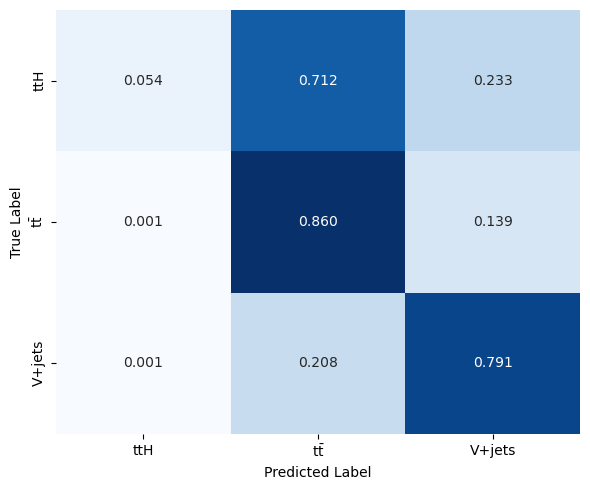

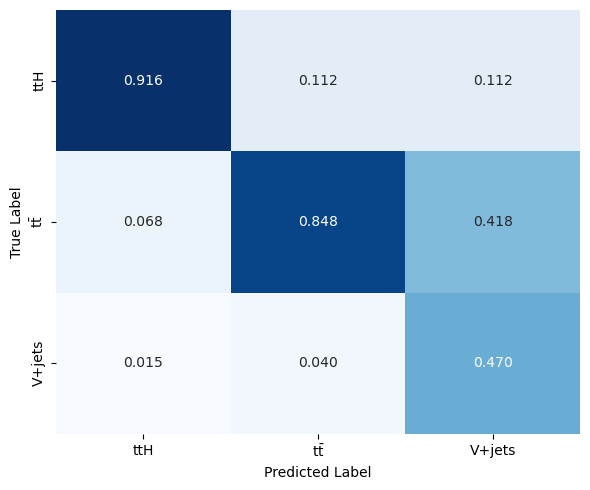

In [12]:
# ...existing code...
import torch
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define class labels
class_labels = ["ttH", r"t$\bar{\mathrm{t}}$", "V+jets"]
num_classes = len(class_labels)

# Example threshold for class "ttH" (class 0)
threshold = 0.89

all_targets = []
all_preds = []
all_probs = []
all_weights = []

model.eval()

# Generate predictions
with torch.no_grad():
    for batch in valid_loader:
        inputs, labels, weights, mask, event = batch
        outputs = model(inputs, padding_mask=mask)  # logits [batch_size, num_classes]

        # Convert logits to probabilities
        probs = F.softmax(outputs, dim=1)

        preds_batch = []
        for p in probs:
            # If probability for class 0 (ttH) is >= threshold, classify as 0
            if p[0].item() >= threshold:
                preds_batch.append(0)
            else:
                # Otherwise, pick whichever is higher: class 1 or class 2
                if p[1].item() >= p[2].item():
                    preds_batch.append(1)
                else:
                    preds_batch.append(2)

        all_preds.extend(preds_batch)
        all_targets.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_weights.extend(weights.cpu().numpy())

y_true = np.array(all_targets)
y_pred = np.array(all_preds)
pred_probs = np.array(all_probs)
event_weights_np = np.array(all_weights) * 200000

# Confusion matrix for classes 0, 1, 2
cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

# Row-normalized confusion matrix
plt.figure(figsize=(6, 5))
row_norm_cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

# Print values and calculations
print("Row-Normalized Confusion Matrix Values:")
for i in range(num_classes):
    for j in range(num_classes):
        value = row_norm_cm[i, j]
        count = cm[i, j]
        row_sum = cm.sum(axis=1)[i]
        calculation = f"{count} / {row_sum}"
        print(f"Cell ({i}, {j}): Value = {value:.3f}, Calculation = {calculation}")

sns.heatmap(row_norm_cm, annot=True, fmt=".3f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
#plt.title("Confusion Matrix (Row-Normalized)")
plt.tight_layout()
plt.show()

# Column-normalized confusion matrix
plt.figure(figsize=(6, 5))
col_norm_cm = cm.astype(float) / cm.sum(axis=0, keepdims=True)
sns.heatmap(col_norm_cm, annot=True, fmt=".3f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
#plt.title("Confusion Matrix (Column-Normalized)")
plt.tight_layout()
plt.show()
# ...existing code...

In [16]:
# trainer.save_checkpoint(f"{outdir}/model.pt")
# print("Checkpoints are being saved in:", outdir)

### Confusion matrix

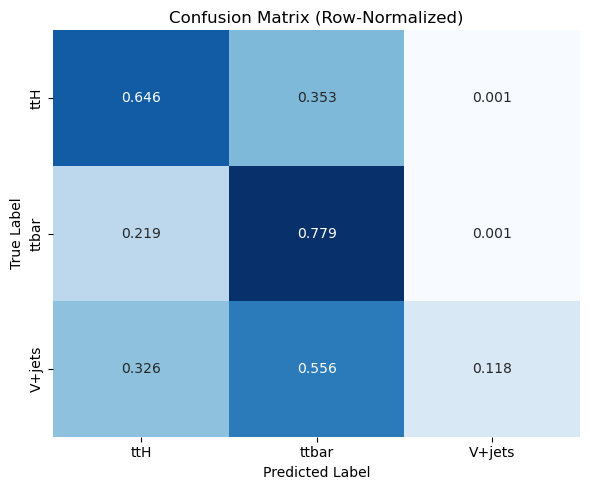

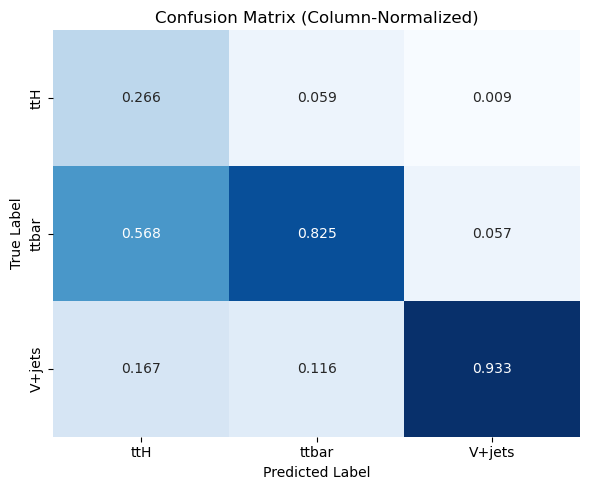

In [11]:
# ...existing code...
import torch
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example threshold for class "2" (e.g., ttH)
threshold = 0.89

all_targets = []
all_preds = []
model.eval()

# Generate predictions
with torch.no_grad():
    for batch in valid_loader:
        inputs, labels, weights, mask, event = batch
        outputs = model(inputs, padding_mask=mask)  # logits [batch_size, 3]

        # Convert logits to probabilities
        probs = F.softmax(outputs, dim=1)

        preds_batch = []
        for p in probs:
            # If probability for class 2 is >= threshold, classify as 2
            if p[2].item() >= threshold:
                preds_batch.append(2)
            else:
                # Otherwise, pick whichever is higher: class 0 or class 1
                preds_batch.append(p[:2].argmax().item())

        all_preds.extend(preds_batch)
        all_targets.extend(labels.cpu().numpy())

y_true = np.array(all_targets)
y_pred = np.array(all_preds)

# Confusion matrix for classes 0, 1, 2
class_labels = ["ttH","ttbar","V+jets"]
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

# Row-normalized confusion matrix
plt.figure(figsize=(6, 5))
row_norm_cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
sns.heatmap(row_norm_cm, annot=True, fmt=".3f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Row-Normalized)")
plt.tight_layout()
plt.show()

# Column-normalized confusion matrix
plt.figure(figsize=(6, 5))
col_norm_cm = cm.astype(float) / cm.sum(axis=0, keepdims=True)
sns.heatmap(col_norm_cm, annot=True, fmt=".3f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Column-Normalized)")
plt.tight_layout()
plt.show()
# ...existing code...

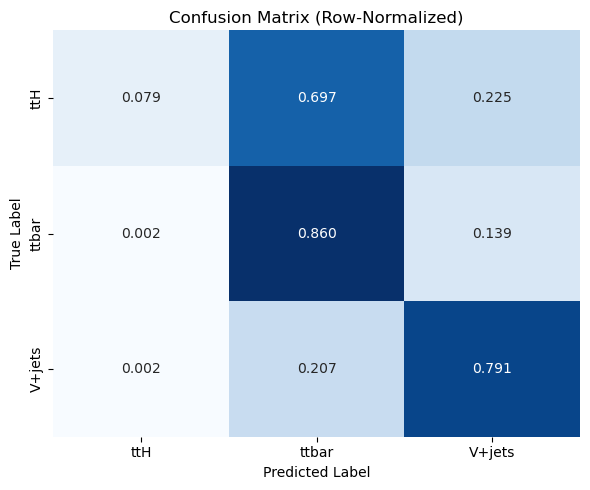

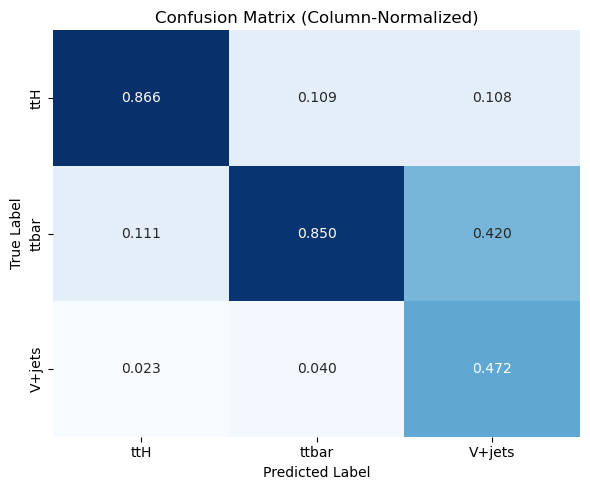

In [15]:
# ...existing code...
import torch
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define class labels
class_labels = ["ttH", "ttbar", "V+jets"]
num_classes = len(class_labels)

# Example threshold for class "ttH" (class 0)
threshold = 0.85

all_targets = []
all_preds = []
model.eval()

# Generate predictions
with torch.no_grad():
    for batch in valid_loader:
        inputs, labels, weights, mask, event = batch
        outputs = model(inputs, padding_mask=mask)  # logits [batch_size, num_classes]

        # Convert logits to probabilities
        probs = F.softmax(outputs, dim=1)

        preds_batch = []
        for p in probs:
            # If probability for class 0 (ttH) is >= threshold, classify as 0
            if p[0].item() >= threshold:
                preds_batch.append(0)
            else:
                # Otherwise, pick whichever is higher: class 1 or class 2
                if p[1].item() >= p[2].item():
                    preds_batch.append(1)
                else:
                    preds_batch.append(2)

        all_preds.extend(preds_batch)
        all_targets.extend(labels.cpu().numpy())

y_true = np.array(all_targets)
y_pred = np.array(all_preds)

# Confusion matrix for classes 0, 1, 2
cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

# Row-normalized confusion matrix
plt.figure(figsize=(6, 5))
row_norm_cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
sns.heatmap(row_norm_cm, annot=True, fmt=".3f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Row-Normalized)")
plt.tight_layout()
plt.show()

# Column-normalized confusion matrix
plt.figure(figsize=(6, 5))
col_norm_cm = cm.astype(float) / cm.sum(axis=0, keepdims=True)
sns.heatmap(col_norm_cm, annot=True, fmt=".3f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Column-Normalized)")
plt.tight_layout()
plt.show()
# ...existing code...

In [13]:
print('torch version', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
print('CUDA version:', torch.version.cuda)
print('cuDNN version:', torch.backends.cudnn.version())

torch version 2.5.1.post303
CUDA available: True
CUDA version: 12.0
cuDNN version: 90300


Row-Normalized Confusion Matrix Values:
Cell (0, 0): Value = 0.054, Calculation = 2550 / 46813
Cell (0, 1): Value = 0.712, Calculation = 33337 / 46813
Cell (0, 2): Value = 0.233, Calculation = 10926 / 46813
Cell (1, 0): Value = 0.001, Calculation = 190 / 294592
Cell (1, 1): Value = 0.860, Calculation = 253476 / 294592
Cell (1, 2): Value = 0.139, Calculation = 40926 / 294592
Cell (2, 0): Value = 0.001, Calculation = 43 / 58162
Cell (2, 1): Value = 0.208, Calculation = 12085 / 58162
Cell (2, 2): Value = 0.791, Calculation = 46034 / 58162


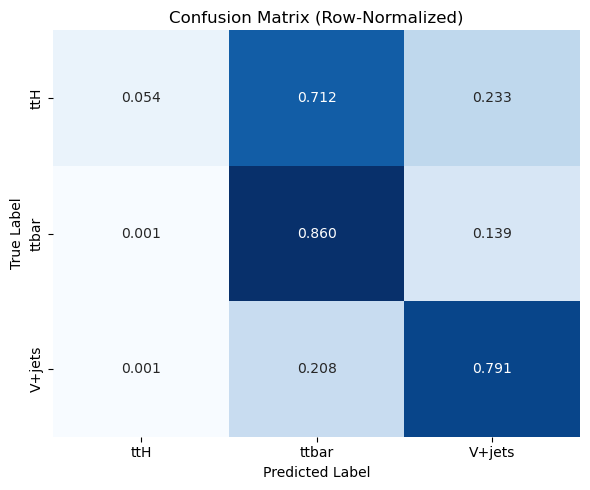

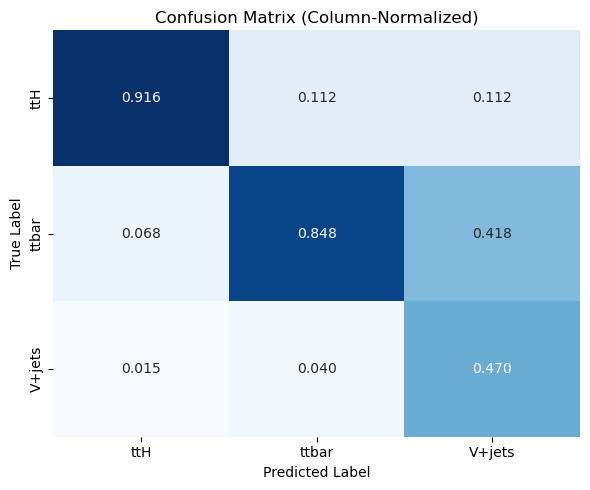

In [16]:
# ...existing code...
import torch
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define class labels
class_labels = ["ttH", "ttbar", "V+jets"]
num_classes = len(class_labels)

# Example threshold for class "ttH" (class 0)
threshold = 0.89

all_targets = []
all_preds = []
model.eval()

# Generate predictions
with torch.no_grad():
    for batch in valid_loader:
        inputs, labels, weights, mask, event = batch
        outputs = model(inputs, padding_mask=mask)  # logits [batch_size, num_classes]

        # Convert logits to probabilities
        probs = F.softmax(outputs, dim=1)

        preds_batch = []
        for p in probs:
            # If probability for class 0 (ttH) is >= threshold, classify as 0
            if p[0].item() >= threshold:
                preds_batch.append(0)
            else:
                # Otherwise, pick whichever is higher: class 1 or class 2
                if p[1].item() >= p[2].item():
                    preds_batch.append(1)
                else:
                    preds_batch.append(2)

        all_preds.extend(preds_batch)
        all_targets.extend(labels.cpu().numpy())

y_true = np.array(all_targets)
y_pred = np.array(all_preds)

# Confusion matrix for classes 0, 1, 2
cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

# Row-normalized confusion matrix
plt.figure(figsize=(6, 5))
row_norm_cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

# Print values and calculations
print("Row-Normalized Confusion Matrix Values:")
for i in range(num_classes):
    for j in range(num_classes):
        value = row_norm_cm[i, j]
        count = cm[i, j]
        row_sum = cm.sum(axis=1)[i]
        calculation = f"{count} / {row_sum}"
        print(f"Cell ({i}, {j}): Value = {value:.3f}, Calculation = {calculation}")

sns.heatmap(row_norm_cm, annot=True, fmt=".3f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Row-Normalized)")
plt.tight_layout()
plt.show()

# Column-normalized confusion matrix
plt.figure(figsize=(6, 5))
col_norm_cm = cm.astype(float) / cm.sum(axis=0, keepdims=True)
sns.heatmap(col_norm_cm, annot=True, fmt=".3f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Column-Normalized)")
plt.tight_layout()
plt.show()
# ...existing code...

Row-Normalized Confusion Matrix Values:
Cell (0, 0): Value = 0.116, Calculation = 5453 / 46813
Cell (0, 1): Value = 0.670, Calculation = 31373 / 46813
Cell (0, 2): Value = 0.213, Calculation = 9987 / 46813
Cell (1, 0): Value = 0.004, Calculation = 1114 / 294592
Cell (1, 1): Value = 0.858, Calculation = 252665 / 294592
Cell (1, 2): Value = 0.139, Calculation = 40813 / 294592
Cell (2, 0): Value = 0.003, Calculation = 188 / 58162
Cell (2, 1): Value = 0.207, Calculation = 12026 / 58162
Cell (2, 2): Value = 0.790, Calculation = 45948 / 58162


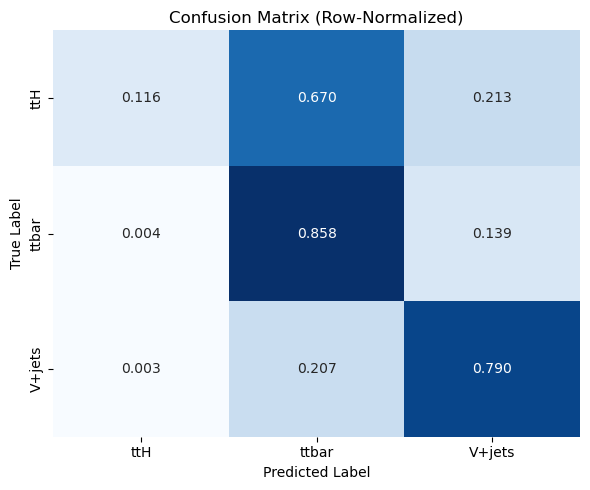

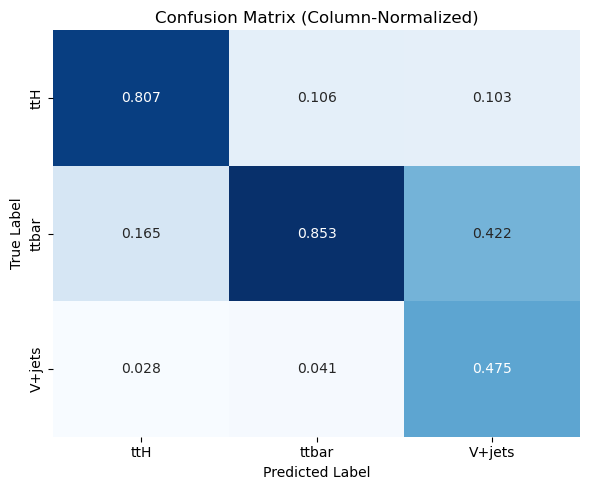

In [18]:
# ...existing code...
import torch
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define class labels
class_labels = ["ttH", "ttbar", "V+jets"]
num_classes = len(class_labels)

# Example threshold for class "ttH" (class 0)
threshold = 0.80

all_targets = []
all_preds = []
model.eval()

# Generate predictions
with torch.no_grad():
    for batch in valid_loader:
        inputs, labels, weights, mask, event = batch
        outputs = model(inputs, padding_mask=mask)  # logits [batch_size, num_classes]

        # Convert logits to probabilities
        probs = F.softmax(outputs, dim=1)

        preds_batch = []
        for p in probs:
            # If probability for class 0 (ttH) is >= threshold, classify as 0
            if p[0].item() >= threshold:
                preds_batch.append(0)
            else:
                # Otherwise, pick whichever is higher: class 1 or class 2
                if p[1].item() >= p[2].item():
                    preds_batch.append(1)
                else:
                    preds_batch.append(2)

        all_preds.extend(preds_batch)
        all_targets.extend(labels.cpu().numpy())

y_true = np.array(all_targets)
y_pred = np.array(all_preds)

# Confusion matrix for classes 0, 1, 2
cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

# Row-normalized confusion matrix
plt.figure(figsize=(6, 5))
row_norm_cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

# Print values and calculations
print("Row-Normalized Confusion Matrix Values:")
for i in range(num_classes):
    for j in range(num_classes):
        value = row_norm_cm[i, j]
        count = cm[i, j]
        row_sum = cm.sum(axis=1)[i]
        calculation = f"{count} / {row_sum}"
        print(f"Cell ({i}, {j}): Value = {value:.3f}, Calculation = {calculation}")

sns.heatmap(row_norm_cm, annot=True, fmt=".3f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Row-Normalized)")
plt.tight_layout()
plt.show()

# Column-normalized confusion matrix
plt.figure(figsize=(6, 5))
col_norm_cm = cm.astype(float) / cm.sum(axis=0, keepdims=True)
sns.heatmap(col_norm_cm, annot=True, fmt=".3f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Column-Normalized)")
plt.tight_layout()
plt.show()
# ...existing code...

In [21]:
conda env export --name hinv-ml > rab_env.yml 

/software/da21592/miniconda3/lib/python3.12/site-packages/conda/base/context.py:982: FutureWarning: Adding 'defaults' to the channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly via 'conda config --add channels <name>', e.g. 'conda config --add channels defaults'.
  deprecated.topic(

Note: you may need to restart the kernel to use updated packages.


In [19]:
conda 

usage: conda [-h] [-v] [--no-plugins] [-V] COMMAND ...

conda is a tool for managing and deploying applications, environments and packages.

options:
  -h, --help          Show this help message and exit.
  -v, --verbose       Can be used multiple times. Once for detailed output,
                      twice for INFO logging, thrice for DEBUG logging, four
                      times for TRACE logging.
  --no-plugins        Disable all plugins that are not built into conda.
  -V, --version       Show the conda version number and exit.

commands:
  The following built-in and plugins subcommands are available.

  COMMAND
    activate          Activate a conda environment.
    clean             Remove unused packages and caches.
    commands          List all available conda subcommands (including those
                      from plugins). Generally only used by tab-completion.
    compare           Compare packages between conda environments.
    config            Modify configuration val

# SHAP

In [31]:
import shap
import torch
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Assuming 'model' is your trained PyTorch model
# and 'valid_loader' is your validation data loader

# Ensure model is in evaluation mode and on the correct device
model.eval()
model.to(device)

# Get a batch of data for background/reference and move it to the correct device
background_data = next(iter(valid_loader))[0].to(device)  # Use the first element (input features)

# Choose an explainer (DeepExplainer or GradientExplainer)
try:
    explainer = shap.DeepExplainer(model, background_data)
except Exception as e:
    print(f"DeepExplainer failed: {e}. Falling back to GradientExplainer.")
    explainer = shap.GradientExplainer(model, background_data)

# Get a batch of data to explain
explainable_data = next(iter(valid_loader))[0].to(device)

# Calculate SHAP values
shap_values = explainer.shap_values(explainable_data)

# Summarize feature importance
shap.summary_plot(shap_values, features=explainable_data.cpu().numpy(),
                  feature_names=data_columns)  # Replace data_columns with your feature names

Using device: cuda


/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f"unrecognized nn.Module: {module_type}")


KeyboardInterrupt: 

In [32]:
import shap
import torch
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Assuming 'model' is your trained PyTorch model
# and 'valid_loader' is your validation data loader

# Ensure model is in evaluation mode and on the correct device
model.eval()
model.to(device)

# --- Optimization: Reduce data size ---
num_background_samples = 100
num_explainable_samples = 100

# Get a batch of data for background/reference and move it to the correct device
background_data = next(iter(valid_loader))[0][:num_background_samples].to(device)  # Use the first element (input features)
explainable_data = next(iter(valid_loader))[0][:num_explainable_samples].to(device)

# Choose an explainer (DeepExplainer or GradientExplainer)
try:
    explainer = shap.DeepExplainer(model, background_data)
except Exception as e:
    print(f"DeepExplainer failed: {e}. Falling back to GradientExplainer.")
    explainer = shap.GradientExplainer(model, background_data)

# Calculate SHAP values
shap_values = explainer.shap_values(explainable_data)

# Summarize feature importance
shap.summary_plot(shap_values, features=explainable_data.cpu().numpy(),
                  feature_names=data_columns)  # Replace data_columns with your feature names

Using device: cuda


AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 1.8461958971379318 - Tolerance: 0.01

# dHH plots

In [18]:
# Example: compute probabilities on validation set
val_probs = model(val_X)          # or however you obtained probabilities for validation
probs_np = val_probs.detach().cpu().numpy()
ttH_probs = probs_np[:, 0]
background_probs = probs_np[:, 1] + probs_np[:, 2]
epsilon = 1e-10
d_hh = np.log(ttH_probs / (background_probs + epsilon))

# Now extract validation labels which should match the number of predictions
labels = val_y.detach().cpu().numpy()

print("d_hh shape:", d_hh.shape)
print("labels shape:", labels.shape)

d_hh shape: (399567,)
labels shape: (399567,)


/tmp/ipykernel_1807425/4217421838.py:7: RuntimeWarning: invalid value encountered in log
  d_hh = np.log(ttH_probs / (background_probs + epsilon))


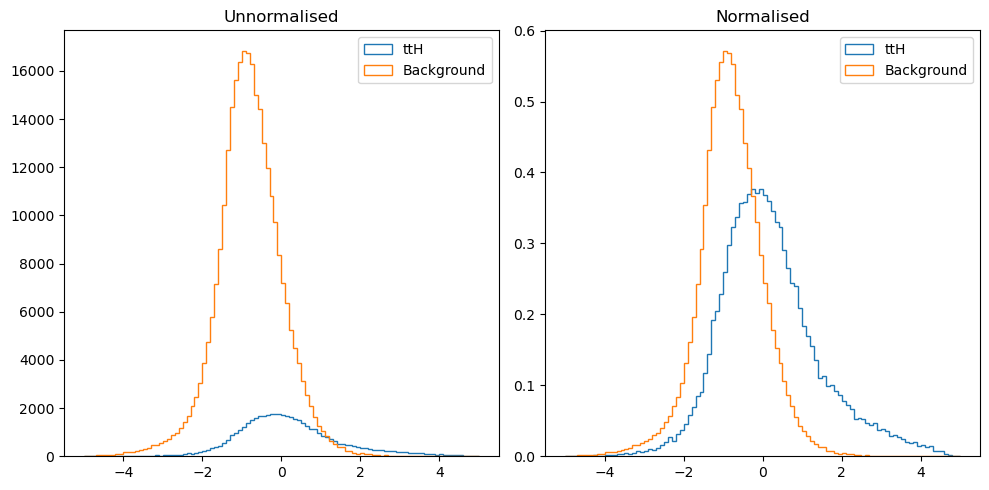

<Figure size 640x480 with 0 Axes>

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Compute d_hh from probabilities (with 2 backgrounds)
# Assuming probs is the tensor of model prediction probabilities (output of softmax)
probs_np = probs.detach().cpu().numpy()  # shape (N, 3)
ttH_probs = probs_np[:, 0]              # Signal probability at index 0
background_probs = probs_np[:, 1] + probs_np[:, 2]  # Sum of the two background probabilities
epsilon = 1e-10  # Avoid division by zero
d_hh = np.log(ttH_probs / (background_probs + epsilon))

# Assume labels_flat (numpy array) exists with 0 for ttH and 1 for background
# Plot two subplots: one unnormalised and one normalised

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True)

axes[0].hist(d_hh[labels == 0], bins=100, range=(-5,5), histtype='step', label='ttH', density=False)
axes[0].hist(d_hh[labels == 1], bins=100, range=(-5,5), histtype='step', label='Background', density=False)
axes[0].legend()
axes[0].set_title('Unnormalised')

axes[1].hist(d_hh[labels == 0], bins=100, range=(-5,5), histtype='step', label='ttH', density=True)
axes[1].hist(d_hh[labels == 1], bins=100, range=(-5,5), histtype='step', label='Background', density=True)
axes[1].legend()
axes[1].set_title('Normalised')

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

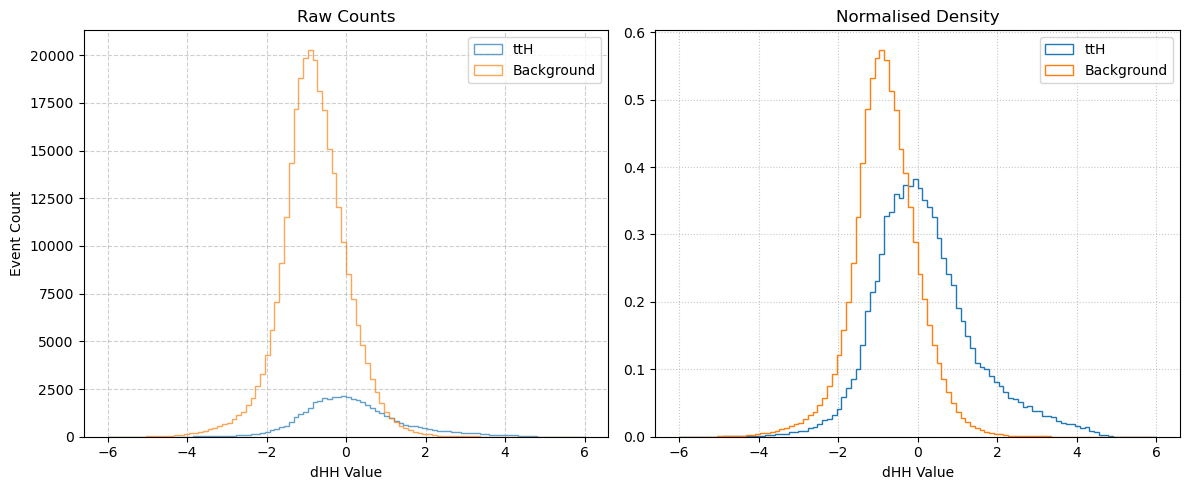

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Compute d_hh from probabilities (with 2 backgrounds)
probs_np = probs.detach().cpu().numpy()  # shape (N, 3)
ttH_probs = probs_np[:, 0]               # Signal probability at index 0
background_probs = probs_np[:, 1] + probs_np[:, 2]  # Sum of two background probabilities
epsilon = 1e-10
d_hh = np.log(ttH_probs / (background_probs + epsilon))

# Use labels derived from validation set
labels = val_y.detach().cpu().numpy()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharex=True)

# Unnormalised - using filled histograms and fewer bins:
ax1.hist(d_hh[labels == 0], bins=100, range=(-6, 6), alpha=0.7, label='ttH', histtype='step')
ax1.hist(d_hh[labels == 1], bins=100, range=(-6, 6), alpha=0.7, label='Background', histtype='step')
ax1.set_title("Raw Counts")
ax1.set_xlabel("dHH Value")
ax1.set_ylabel("Event Count")
ax1.legend()
ax1.grid(linestyle='--', alpha=0.6)

# Normalised - using step histograms with thicker lines:
ax2.hist(d_hh[labels == 0], bins=100, range=(-6, 6), density=True, histtype='step', label='ttH')
ax2.hist(d_hh[labels == 1], bins=100, range=(-6, 6), density=True, histtype='step', label='Background')
ax2.set_title("Normalised Density")
ax2.set_xlabel("dHH Value")
ax2.legend()
ax2.grid(linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

In [21]:
print("d_hh shape:", d_hh.shape)
print("labels shape:", labels.shape)  # or labels_flat.shape if using that variable

d_hh shape: (399567,)
labels shape: (399567,)



No systematic:
Max significance: 6.26 at d_hh threshold: 3.351
Signal (S): 12.2
Background (B): 3.8

5% systematic:
Max significance: 6.23 at d_hh threshold: 3.351
Signal (S): 12.2
Background (B): 3.8

10% systematic:
Max significance: 6.15 at d_hh threshold: 3.351
Signal (S): 12.2
Background (B): 3.8


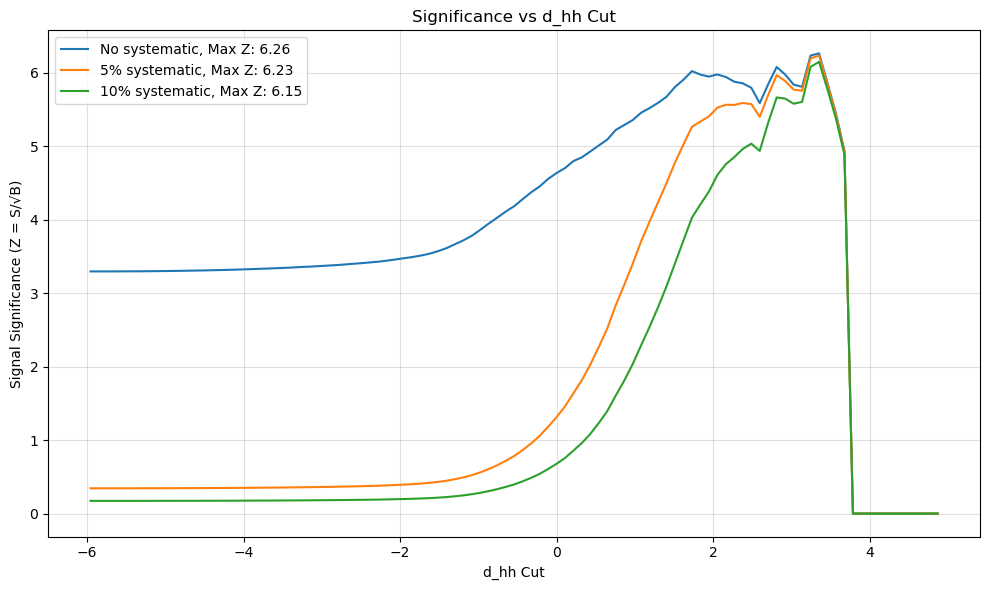

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# (Assuming d_hh was computed already from your probabilities)
# d_hh = np.log(ttH_probs / (background_probs + epsilon))
# And assume ground truth and event weights are available:
truth = labels.flatten()  # ground truth: 0 = signal, 1 = background
event_weights_np = (val_weight_nominal * 200000).detach().cpu().numpy().flatten()

# Prepare d_hh thresholds (cut values) spanning the observed range
thresh_points = np.linspace(np.min(d_hh), np.max(d_hh), 101)

significance_0 = []
significance_5 = []
significance_10 = []

for cut in thresh_points:
    # Treat events with d_hh greater than the cut as "signal-like"
    signal_mask = (d_hh > cut) & (truth == 0)
    bkg_mask = (d_hh > cut) & (truth != 0)
    
    # Weighted signal and background
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    
    # Only compute significance if both S and B are non-negligible
    if S > 2 and B > 2:
        significance_0.append(S / np.sqrt(B))
        significance_5.append(S / np.sqrt(B + (0.05 * B) ** 2))
        significance_10.append(S / np.sqrt(B + (0.10 * B) ** 2))
    else:
        significance_0.append(0)
        significance_5.append(0)
        significance_10.append(0)

# Find max significance and corresponding threshold for each systematic scenario
significance_0 = np.array(significance_0)
significance_5 = np.array(significance_5)
significance_10 = np.array(significance_10)

max_0 = np.max(significance_0)
max_5 = np.max(significance_5)
max_10 = np.max(significance_10)

idx_0 = np.argmax(significance_0)
idx_5 = np.argmax(significance_5)
idx_10 = np.argmax(significance_10)

thresh_0 = thresh_points[idx_0]
thresh_5 = thresh_points[idx_5]
thresh_10 = thresh_points[idx_10]

# Print out details at the optimal thresholds
for thresh_val, sig, label_tag in zip(
    [thresh_0, thresh_5, thresh_10],
    [max_0, max_5, max_10],
    ['No systematic', '5% systematic', '10% systematic']
):
    s_mask = (d_hh > thresh_val) & (truth == 0)
    b_mask = (d_hh > thresh_val) & (truth != 0)
    S = np.sum(event_weights_np[s_mask])
    B = np.sum(event_weights_np[b_mask])
    
    print(f"\n{label_tag}:")
    print(f"Max significance: {sig:.2f} at d_hh threshold: {thresh_val:.3f}")
    print(f"Signal (S): {S:.1f}")
    print(f"Background (B): {B:.1f}")

# Plot significance vs. d_hh cut
plt.figure(figsize=(10, 6))
plt.plot(thresh_points, significance_0, label=f'No systematic, Max Z: {max_0:.2f}')
plt.plot(thresh_points, significance_5, label=f'5% systematic, Max Z: {max_5:.2f}')
plt.plot(thresh_points, significance_10, label=f'10% systematic, Max Z: {max_10:.2f}')
plt.xlabel('d_hh Cut')
plt.ylabel('Signal Significance (Z = S/√B)')
plt.title('Significance vs d_hh Cut')
plt.grid(alpha=0.4)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Pretty plot for report


No systematic:
Max significance: 6.52
At threshold: 0.890
S: 33.3
B: 26.2

5% systematic:
Max significance: 6.32
At threshold: 0.890
S: 33.3
B: 26.2

10% systematic:
Max significance: 5.95
At threshold: 0.920
S: 22.2
B: 12.4


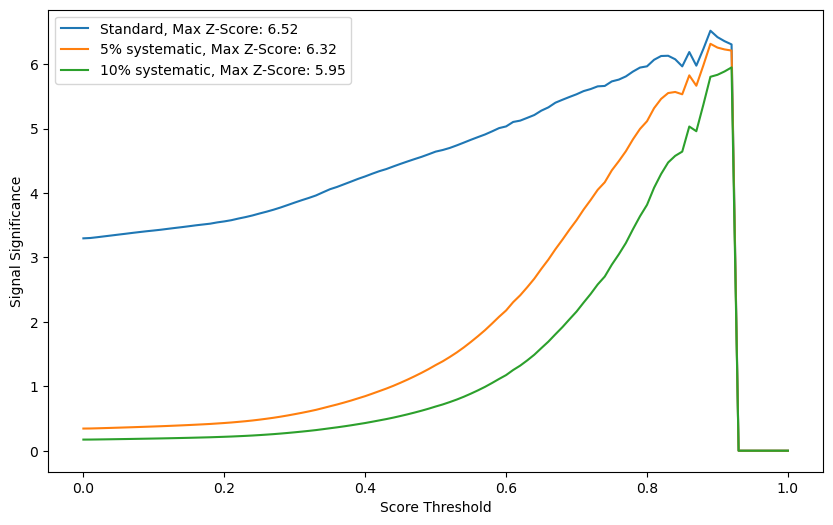

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Convert model outputs to probabilities for each class using softmax (preds.shape => [N, 3])


# Assuming preds[:, 0] corresponds to signal probability
pred_probs = torch.softmax(preds, dim=1).detach().cpu().numpy()  # shape (N,3)

# For Z-score calculation, use probability of signal (class=0)
signal_scores = pred_probs[:, 0].flatten()

# Ground truth: 0 => signal, 1 or 2 => background
truth = labels.detach().cpu().numpy().flatten()

# Weigh events (example: multiply nominal weights by 2e5 for convenience)
#event_weights_np = val_weight_nominal.clone().detach().cpu().numpy().flatten() * 200000
event_weights_np = np.array((val_weight_nominal *200000).flatten())

# Prepare thresholds
thresh_points = np.linspace(0, 1, 101)
significance_0 = []
significance_5 = []
significance_10 = []

for cut in thresh_points:
    # Events passing threshold
    signal_mask = (signal_scores > cut) & (truth == 0)
    bkg_mask = (signal_scores > cut) & (truth != 0)
    
    # Weighted S and B
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    
    if S >= 10 and B >= 10:
        significance_0.append(S / np.sqrt(B))
        significance_5.append(S / np.sqrt(B + (0.05 * B) ** 2))
        significance_10.append(S / np.sqrt(B + (0.10 * B) ** 2))
    else:
        significance_0.append(0)
        significance_5.append(0)
        significance_10.append(0)

# Find max significance & thresholds
max_0 = np.max(significance_0)
max_5 = np.max(significance_5)
max_10 = np.max(significance_10)

idx_0 = np.argmax(significance_0)
idx_5 = np.argmax(significance_5)
idx_10 = np.argmax(significance_10)

thresh_0 = thresh_points[idx_0]
thresh_5 = thresh_points[idx_5]
thresh_10 = thresh_points[idx_10]

# Print info at these thresholds
for thresh_val, sig, label in zip(
    [thresh_0, thresh_5, thresh_10],
    [max_0, max_5, max_10],
    ['No systematic', '5% systematic', '10% systematic']
):
    signal_mask = (signal_scores > thresh_val) & (truth == 0)
    bkg_mask = (signal_scores > thresh_val) & (truth != 0)
    S = np.sum(event_weights_np[signal_mask])
    B = np.sum(event_weights_np[bkg_mask])
    
    print(f"\n{label}:")
    print(f"Max significance: {sig:.2f}")
    print(f"At threshold: {thresh_val:.3f}")
    print(f"S: {S:.1f}")
    print(f"B: {B:.1f}")

# Plot
plt.figure(figsize=(10,6))
plt.plot(thresh_points, significance_0, label=f'Standard, Max Z-Score: {max_0:.2f}')
plt.plot(thresh_points, significance_5, label=f'5% systematic, Max Z-Score: {max_5:.2f}')
plt.plot(thresh_points, significance_10, label=f'10% systematic, Max Z-Score: {max_10:.2f}')

plt.xlabel('Score Threshold')
plt.ylabel('Signal Significance')
#plt.title('Multiclass Z-Score vs Threshold')
#plt.grid(alpha=0.3)
plt.legend(loc='upper left')
plt.show()